## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [5]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 2. Create Gaussian blurs with different widths

In [6]:
# Number of Gaussian blurs images per class
nPerClass = 1500

# Pixel size : heightxwidth = 91x91
imgSize   = 91

x = np.linspace(start=-4, stop=4, num=imgSize)

# Return coordinate matrices from coordinate vectors.
X,Y = np.meshgrid(x,x)

# sigma value : two widths 
# widths have arbitary units
widths = [1.8,2.4]

# initialize tensors containing images and labels
# 1 : grey scale channel
images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

    # Create the gaussian with random centers
    # Return a sample (or samples) from the "standard normal" distribution.
    # ro = random offset
    ro = 2*np.random.randn(2)    
    
    G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

    # add noise
    G  = G + np.random.randn(imgSize,imgSize)/5

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i] = i%2

# Reshaping into 2D array
labels = labels[:,None]

#### Visualizing some images

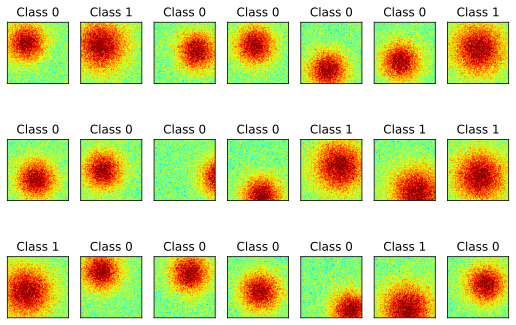

In [7]:
fig,axes = plt.subplots(3,7,figsize=(9,6), dpi=135)

for i,ax in enumerate(axes.flatten()):
    
    whichpic = np.random.randint(2*nPerClass)
    
    G = np.squeeze( images[whichpic,:,:] )
    
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    
    ax.set_title(f'Class {int(labels[whichpic].item())}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 3. Create DataLoader

#### (i) Train-Test split

In [8]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.15)

#### (ii) Convert into PyTorch Datasets

In [9]:
train_dataset = TensorDataset(train_data,train_labels)
test_dataset  = TensorDataset(test_data,test_labels)

#### (iii) Translate into dataloader objects

In [10]:
batchsize    = 32

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=test_dataset.tensors[0].shape[0])

In [11]:
# check size (should be No. of images x No. of channels x width X height)
train_loader.dataset.tensors[0].shape

torch.Size([2550, 1, 91, 91])

In [12]:
test_loader.dataset.tensors[0].shape

torch.Size([450, 1, 91, 91])

## 4. Create a custom DL model

#### For Convolution layer :
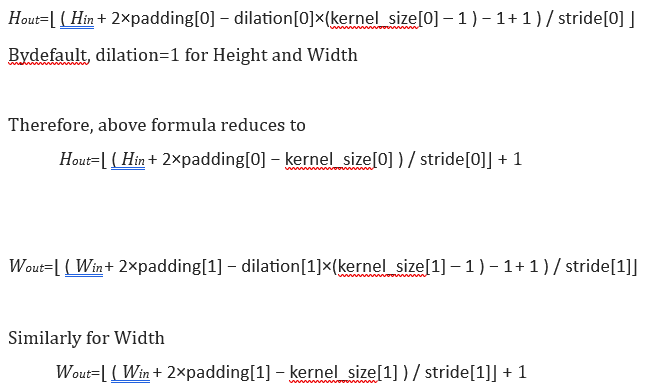

#### For Pooling Layer :
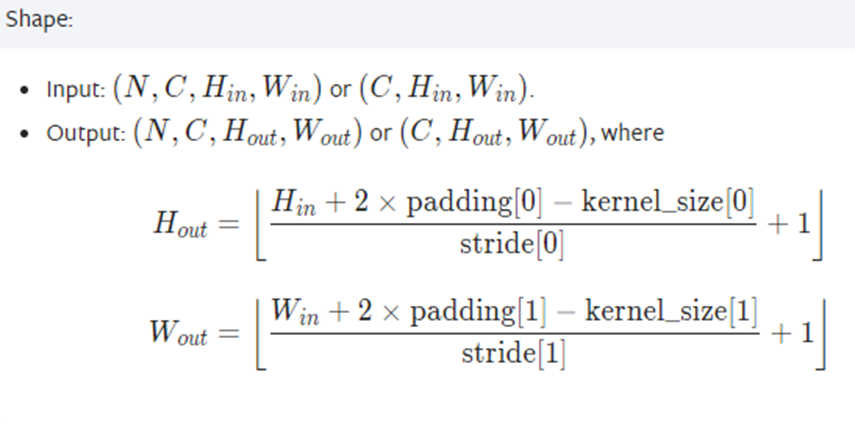

In [13]:
def makeTheNet(inp_imgW,inp_imgH,LR):

    class gausnet(nn.Module):
        
        def __init__(self):
            super().__init__()
            
            # Defining the Kernel and Stride
            k = (3,2)
            s = (2,3)
            
            # First Conv and Pooling layer block
            # conv1 layer : 
            self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=k,padding=1,stride=s)
            
            # output(width and Height) from first convolution layer 'self.conv1' 
            imsizeW = np.floor( (inp_imgW + 2*self.conv1.padding[1] - k[1] ) / s[1] ) + 1
            imsizeH = np.floor( (inp_imgH + 2*self.conv1.padding[0] - k[0] ) / s[0] ) + 1
            
            # Pooling layer : 
            # Dividing by 2 because of Pooling window (i.e., Kernel size) = (2,2) defined in
            # avg_pool2d(conv1act,kernel_size=(2,2))
            imsizeW = np.floor( imsizeW/2 )
            imsizeH = np.floor( imsizeH/2 )
                        

            # Second Conv and Pooling layer block
            # conv2 layer : 
            self.conv2 = nn.Conv2d(in_channels=6,out_channels=4,kernel_size=k,padding=1,stride=s)
            
            # output(width and Height) from first convolution layer 'self.conv1' 
            imsizeW = np.floor( (imsizeW + 2*self.conv1.padding[1] - k[1] ) / s[1] ) + 1
            imsizeH = np.floor( (imsizeH + 2*self.conv1.padding[0] - k[0] ) / s[0] ) + 1
            
            # Pooling layer : 
            # Dividing by 2 because of Pooling window (i.e., Kernel size) = (2,2) defined in
            # avg_pool2d(conv1act,kernel_size=(2,2))
            imsizeW = np.floor( imsizeW/2 )
            imsizeH = np.floor( imsizeH/2 )
            
            
            # fc1 layer
            # Number of Input Features : imsizeW*imsizeH*(self.conv2.out_channels=4)
            # Number of Neuron in output : 50
            in_feat = int(imsizeW*imsizeH*self.conv2.out_channels)
            self.fc1 = nn.Linear(in_feat, 50)

            # fc2 output layer
            # Number of input features : 50
            # Number of Neuron in output : 1
            self.fc2 = nn.Linear(50,1)
      
        def forward(self,x):
            
            # first conv-pool set
            conv1act = F.relu(self.conv1(x))
            
            x = F.avg_pool2d(conv1act,kernel_size=(2,2))

            # second conv-pool set
            conv2act = F.relu(self.conv2(x))
            
            x = F.avg_pool2d(conv2act,kernel_size=(2,2))

            # ANN part : fc1 layer & fc2 (output) layer
            x = x.reshape(x.shape[0],-1)
            
            x = F.relu( self.fc1(x) )
            x = self.fc2(x)
      
            return x,conv1act,conv2act
  
    # create the model instance
    net = gausnet()

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=LR)

    return net,lossfunc,optimizer

#### Testing

In [14]:
# Test the model with one batch
net_test, lossfunc_test, optimizer_test = makeTheNet(inp_imgW=imgSize, inp_imgH=imgSize, LR=0.001)

X,y = next(iter(train_loader))

yHat_test, featmap1, featmap2 = net_test(X)

# let's compute the loss
loss_test=lossfunc_test(yHat_test,y)

# check sizes of outputs
print('Predicted category:')
print(yHat_test.shape)

print('\nFeature map after conv1')
print(featmap1.shape)

print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 6, 46, 31])

Feature map after conv2
torch.Size([32, 4, 12, 6])


#### Summary

In [15]:
# count the total number of parameters in the model
summary(net_test,(1,imgSize,imgSize));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 46, 31]           42
├─Conv2d: 1-2                            [-1, 4, 12, 6]            148
├─Linear: 1-3                            [-1, 50]                  3,650
├─Linear: 1-4                            [-1, 1]                   51
Total params: 3,891
Trainable params: 3,891
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.03
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.11


## 5. Model Training

In [16]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):
    
    #losses = torch.zeros(epochs)
    train_loss = torch.zeros(epochs)
    test_loss = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)[0]    # We only need the first output during Forward pass
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = (yHat_train>0) ==y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
            
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        #losses[epochi] = np.round(np.mean(batchLoss),2)
        train_loss[epochi] = np.round(np.mean(batchLoss),2)
        
        # Test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            
            yHat_test = Model(X)[0]  # We only need the first output during Forward pass
            loss = lossfunc(yHat_test,y)
        
        test_loss[epochi] = loss.item()
        
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round( 100*torch.mean(( (yHat_test>0) ==y).float()).item(),2  ) )
        # End epochs

    # function output
    return trainAcc,testAcc,train_loss,test_loss,Model

## 6.  Run the model

In [17]:
CNN_Gaussian_model, lossfunc, Optimizer = makeTheNet(inp_imgW=imgSize, inp_imgH=imgSize, LR=0.001)

In [18]:
# took 5mins 
TrainAcc,TestAcc,Train_loss,Test_loss,trained_Model=function2trainTheModel(Model=CNN_Gaussian_model , 
                                                             lossfunc=lossfunc , 
                                                             optimizer=Optimizer,
                                                             train_loader=train_loader , 
                                                             test_loader=test_loader, 
                                                             epochs=25)

## 7. Results Visualization

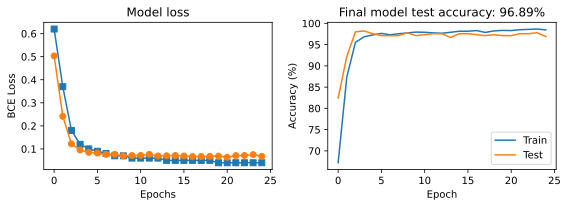

In [19]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(Train_loss,'s-',label='Train')
ax[0].plot(Test_loss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('BCE Loss')
ax[0].set_title('Model loss')

ax[1].plot(TrainAcc,label='Train')
ax[1].plot(TestAcc, label='Test')

ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc[-1]:.2f}%')
ax[1].legend()

fig.tight_layout()

plt.show()

## 8. Visualize some Images

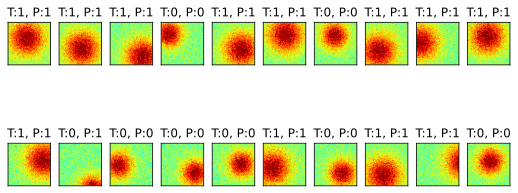

In [20]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = trained_Model(X)  # yHat : real number greater than or less than one

fig,axs = plt.subplots(2,10,figsize=(9,4), dpi=135)

for i,ax in enumerate(axs.flatten()):
    
    G = torch.squeeze( X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    
    t = ( int(y[i].item()) , int(yHat[i].item()>0) )
    
    ax.set_title('T:%s, P:%s'%t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 9. Draw the feature maps

In [21]:
X.shape

torch.Size([450, 1, 91, 91])

In [22]:
featmap1.shape

torch.Size([450, 6, 46, 31])

#### (i) Feature maps from the conv1 layer

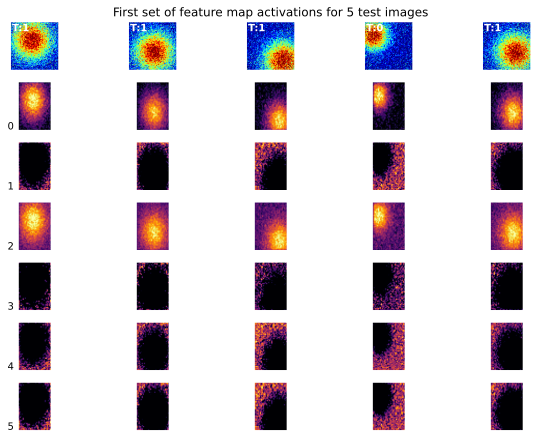

In [23]:
fig,axs = plt.subplots(7,5,figsize=(9,6), dpi=135)

for pici in range(5):

    # Show the original picture
    # X : 4D tensor with 3D as its elements
    # X[pici=0] : first element(3D) of X 
    # X[pici,0] : first element(2D) of X[pici] 
    img = X[pici,0,:,:].detach()
    
    axs[0,pici].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0,pici].axis('off')
    axs[0,pici].text(2,2,f'T:{int(y[pici].item())}', ha='left', va='top', color='w',fontweight='bold')

    for feati in range(6): # 6: Number of activation map from conv1 layer
        
        # Extract the feature map from this image
        act_map1 = featmap1[pici,feati,:,:].detach()
        
        axs[feati+1,pici].imshow(act_map1, cmap='inferno',vmin=0,vmax=torch.max(act_map1)*.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 5 test images',x=.5,y=1.01)
plt.show()

#### (ii) Feature maps from the conv2 layer

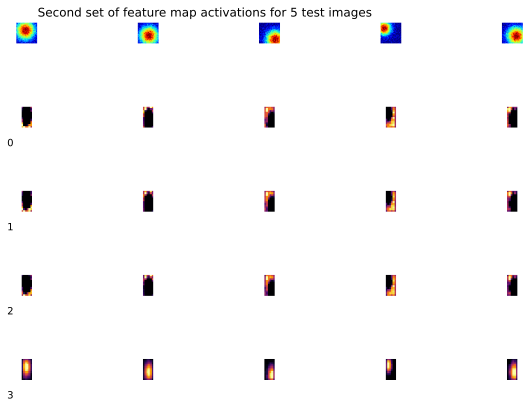

In [24]:
fig,axs = plt.subplots(5,5,figsize=(9,6), dpi=135)

for pici in range(5):

    # Show the original picture
    img = X[pici,0,:,:].detach()

    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')

    for feati in range(4): # 4: Number of activation map from conv2 layer
    
        # Extract the feature map from this image
        act_map2 = featmap2[pici,feati,:,:].detach()
        
        axs[feati+1,pici].imshow(act_map2,cmap='inferno',vmin=0,vmax=torch.max(act_map2)*.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 5 test images',x=.4,y=1.01)
plt.show()